In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName("product_sales").getOrCreate()

print(spark)

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

schema = StructType([
    StructField("Product Id", IntegerType(), True),
    StructField("Product Name", StringType(), True),
    StructField("Product Price", DoubleType(), True)
])
products_df = spark.read.option("header","true").option('inferschema','true').csv('DataSet/products.csv',schema=schema)
products_df.printSchema()
products_df.show()

root
 |-- Product Id: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Product Price: double (nullable = true)

+----------+------------+-------------+
|Product Id|Product Name|Product Price|
+----------+------------+-------------+
|         1|       PIZZA|        100.0|
|         2|     Chowmin|        150.0|
|         3|    sandwich|        120.0|
|         4|        Dosa|        110.0|
|         5|     Biryani|         80.0|
|         6|       Pasta|        180.0|
+----------+------------+-------------+



In [ ]:
sales_df = spark.read.option("header","true").option('inferschema','true').csv('DataSet/sales.csv')
sales_df.printSchema()
sales_df.show()

root
 |-- Product Id: integer (nullable = true)
 |-- Customer Id: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Quantity: integer (nullable = true)

+----------+-----------+-------------------+--------+----------+--------+
|Product Id|Customer Id|               Date|Location|    Source|Quantity|
+----------+-----------+-------------------+--------+----------+--------+
|         1|          A|2023-01-01 00:00:00|   India|    Swiggy|       1|
|         2|          A|2022-01-01 00:00:00|   India|    Swiggy|       2|
|         2|          A|2023-01-07 00:00:00|   India|    Swiggy|       3|
|         3|          A|2023-01-10 00:00:00|   India|Restaurant|       1|
|         3|          A|2022-01-11 00:00:00|   India|    Swiggy|       1|
|         3|          A|2023-01-11 00:00:00|   India|Restaurant|       3|
|         2|          B|2022-02-01 00:00:00|   India|    Swiggy|       2|
|         

In [ ]:
from pyspark.sql.functions import *;
# Join sales_df and products_df on Product Id
exchange_rate = 83
products_df = products_df.withColumnRenamed("Product Price", "Product_Price_USD")
products_df = products_df.withColumn("Product_Price_INR", col("Product_Price_USD") * exchange_rate)

# Check the schema and data of joined_df
products_df.printSchema()
products_df.show()

root
 |-- Product Id: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Product_Price_USD: double (nullable = true)
 |-- Product_Price_INR: double (nullable = true)

+----------+------------+-----------------+-----------------+
|Product Id|Product Name|Product_Price_USD|Product_Price_INR|
+----------+------------+-----------------+-----------------+
|         1|       PIZZA|            100.0|           8300.0|
|         2|     Chowmin|            150.0|          12450.0|
|         3|    sandwich|            120.0|           9960.0|
|         4|        Dosa|            110.0|           9130.0|
|         5|     Biryani|             80.0|           6640.0|
|         6|       Pasta|            180.0|          14940.0|
+----------+------------+-----------------+-----------------+



In [ ]:
joined_df = sales_df.join(products_df, on="Product Id", how= "inner")
joined_df.show()

+----------+-----------+-------------------+--------+----------+--------+------------+-----------------+-----------------+
|Product Id|Customer Id|               Date|Location|    Source|Quantity|Product Name|Product_Price_USD|Product_Price_INR|
+----------+-----------+-------------------+--------+----------+--------+------------+-----------------+-----------------+
|         1|          A|2023-01-01 00:00:00|   India|    Swiggy|       1|       PIZZA|            100.0|           8300.0|
|         2|          A|2022-01-01 00:00:00|   India|    Swiggy|       2|     Chowmin|            150.0|          12450.0|
|         2|          A|2023-01-07 00:00:00|   India|    Swiggy|       3|     Chowmin|            150.0|          12450.0|
|         3|          A|2023-01-10 00:00:00|   India|Restaurant|       1|    sandwich|            120.0|           9960.0|
|         3|          A|2022-01-11 00:00:00|   India|    Swiggy|       1|    sandwich|            120.0|           9960.0|
|         3|    

In [ ]:
# 1. Calculate the total amount spent by each customer
customer_spent_df = joined_df.groupBy("Customer Id") \
    .agg(sum((col("Quantity") * col("Product_Price_USD"))).alias("Total_Amount_Spent_USD"),
         sum((col("Quantity") * col("Product_Price_INR"))).alias("Total_Amount_Spent_INR"))

# Show total amount spent by each customer
customer_spent_df.show()

+-----------+----------------------+----------------------+
|Customer Id|Total_Amount_Spent_USD|Total_Amount_Spent_INR|
+-----------+----------------------+----------------------+
|          E|               15630.0|             1297290.0|
|          B|               19440.0|             1613520.0|
|          D|                4280.0|              355240.0|
|          C|                6560.0|              544480.0|
|          A|               13830.0|             1147890.0|
+-----------+----------------------+----------------------+



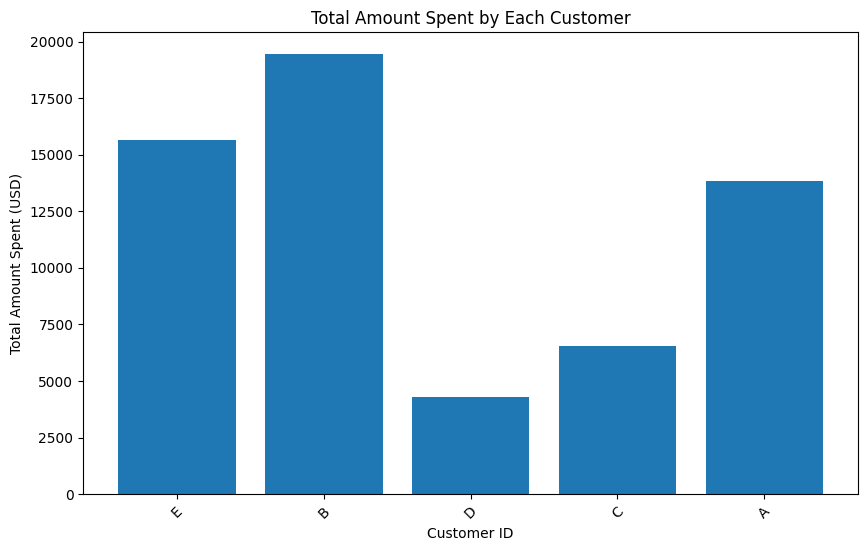

In [ ]:
# Extracting data from DataFrame to lists
customer_spent_data = customer_spent_df.collect()
customer_ids = [row['Customer Id'] for row in customer_spent_data]
total_amount_spent = [row['Total_Amount_Spent'] for row in customer_spent_data]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(customer_ids, total_amount_spent)
plt.xlabel('Customer ID')
plt.ylabel('Total Amount Spent(USD)')
plt.title('Total Amount Spent by Each Customer')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 2. Calculate the total amount spent by each food category
food_category_spent_df = joined_df.groupBy("Product Name") \
    .agg(sum((col("Quantity") * col("Product_Price_USD"))).alias("Total_Amount_Spent_USD"),
         sum((col("Quantity") * col("Product_Price_INR"))).alias("Total_Amount_Spent_INR"))

# Show total amount spent by each food category
food_category_spent_df.show()


+------------+----------------------+----------------------+
|Product Name|Total_Amount_Spent_USD|Total_Amount_Spent_INR|
+------------+----------------------+----------------------+
|       Pasta|                3600.0|              298800.0|
|       PIZZA|                5600.0|              464800.0|
|    sandwich|               28560.0|             2370480.0|
|     Biryani|                2000.0|              166000.0|
|     Chowmin|               16350.0|             1357050.0|
|        Dosa|                3630.0|              301290.0|
+------------+----------------------+----------------------+



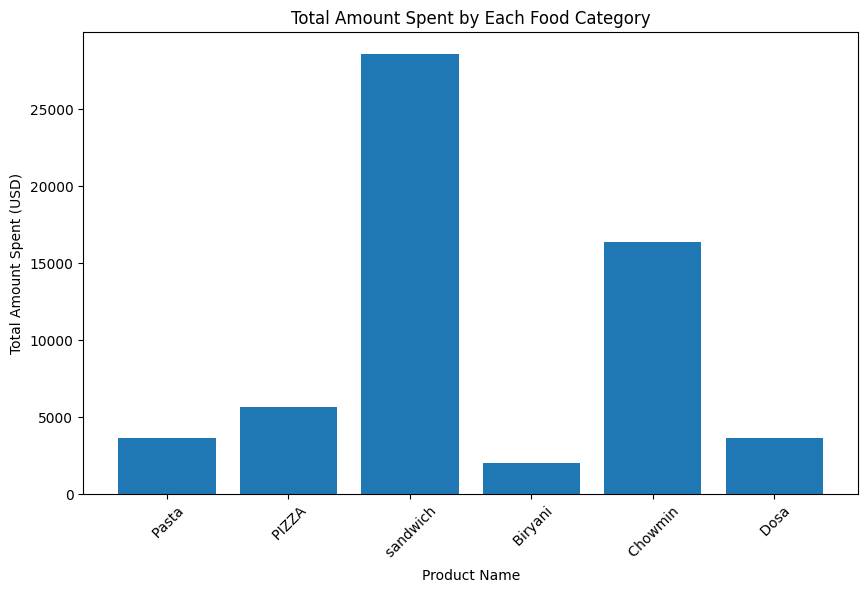

In [ ]:
# 2. Total Amount Spent by each food category
food_category_spent_data = food_category_spent_df.collect()
product_names = [row['Product Name'] for row in food_category_spent_data]
total_amount_spent_usd = [row['Total_Amount_Spent_USD'] for row in food_category_spent_data]

plt.figure(figsize=(10, 6))
plt.bar(product_names, total_amount_spent_usd)
plt.xlabel('Product Name')
plt.ylabel('Total Amount Spent (USD)')
plt.title('Total Amount Spent by Each Food Category')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 3
from pyspark.sql.functions import month

# Extract the month from the Date column and calculate total sales in each month
sales_df_monthly = joined_df.withColumn("Month", month("Date")) \
    .groupBy("Month") \
    .agg(sum((col("Quantity") * col("Product_Price_USD"))).alias("Total_Sales_USD"),
         sum((col("Quantity") * col("Product_Price_INR"))).alias("Total_Sales_INR")) \
    .orderBy("Month")

# Show total sales in each month
sales_df_monthly.show()


+-----+---------------+---------------+
|Month|Total_Sales_USD|Total_Sales_INR|
+-----+---------------+---------------+
|    1|         8600.0|       713800.0|
|    2|        22150.0|      1838450.0|
|    3|         1760.0|       146080.0|
|    5|        12800.0|      1062400.0|
|    6|         8230.0|       683090.0|
|    7|         2540.0|       210820.0|
|   11|         3660.0|       303780.0|
+-----+---------------+---------------+



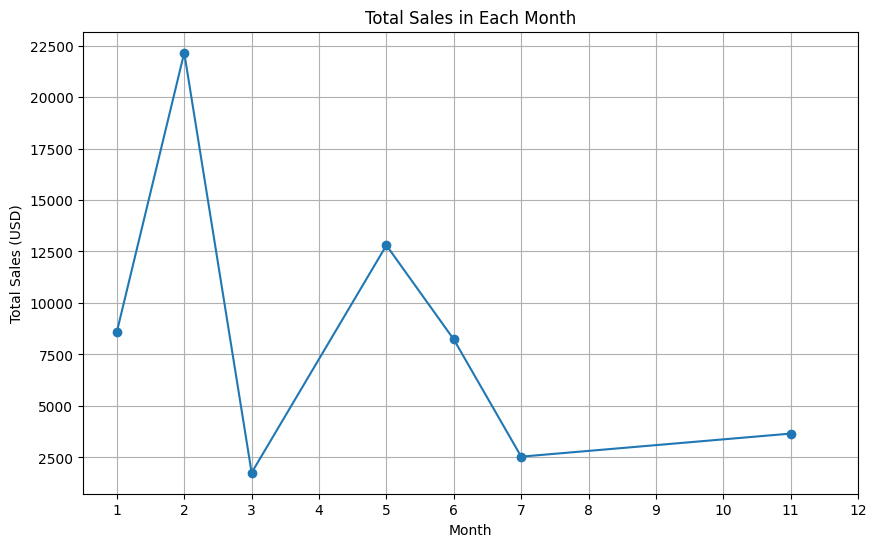

In [ ]:
# 3
# Extract data for plotting
sales_df_monthly_data = sales_df_monthly.collect()
months = [row['Month'] for row in sales_df_monthly_data]
total_sales_usd = [row['Total_Sales_USD'] for row in sales_df_monthly_data]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(months, total_sales_usd, marker='o', color='b', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sales (USD)')
plt.title('Total Sales in Each Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


In [ ]:
# 4. Extract the year from the Date column and calculate the yearly sales
sales_df_yearly = joined_df.withColumn("Year", year("Date")) \
    .groupBy("Year") \
    .agg(sum(col("Quantity") * col("Product_Price_USD")).alias("Yearly_Sales_USD"),
         sum(col("Quantity") * col("Product_Price_INR")).alias("Yearly_Sales_INR"))

# Show yearly sales
sales_df_yearly.show()

+----+----------------+----------------+
|Year|Yearly_Sales_USD|Yearly_Sales_INR|
+----+----------------+----------------+
|2023|         43490.0|       3609670.0|
|2022|         16250.0|       1348750.0|
+----+----------------+----------------+



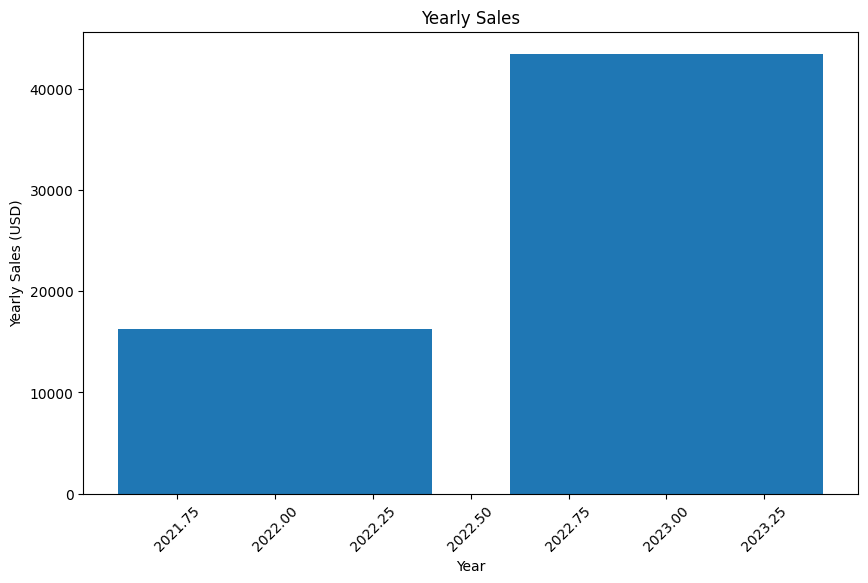

In [ ]:
# 4. Yearly Sales
sales_df_yearly_data = sales_df_yearly.collect()
years = [row['Year'] for row in sales_df_yearly_data]
yearly_sales_usd = [row['Yearly_Sales_USD'] for row in sales_df_yearly_data]

plt.figure(figsize=(10, 6))
plt.bar(years, yearly_sales_usd)
plt.xlabel('Year')
plt.ylabel('Yearly Sales (USD)')
plt.title('Yearly Sales')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 5. Extract the quarter from the Date column and calculate the quarterly sales
sales_df_quarterly = joined_df.withColumn("Quarter", quarter("Date")) \
    .groupBy("Quarter") \
    .agg(sum(col("Quantity") * col("Product_Price_USD")).alias("Quarterly_Sales_USD"),
         sum(col("Quantity") * col("Product_Price_INR")).alias("Quarterly_Sales_INR"))

# Show quarterly sales
sales_df_quarterly.show()

+-------+-------------------+-------------------+
|Quarter|Quarterly_Sales_USD|Quarterly_Sales_INR|
+-------+-------------------+-------------------+
|      1|            32510.0|          2698330.0|
|      3|             2540.0|           210820.0|
|      4|             3660.0|           303780.0|
|      2|            21030.0|          1745490.0|
+-------+-------------------+-------------------+



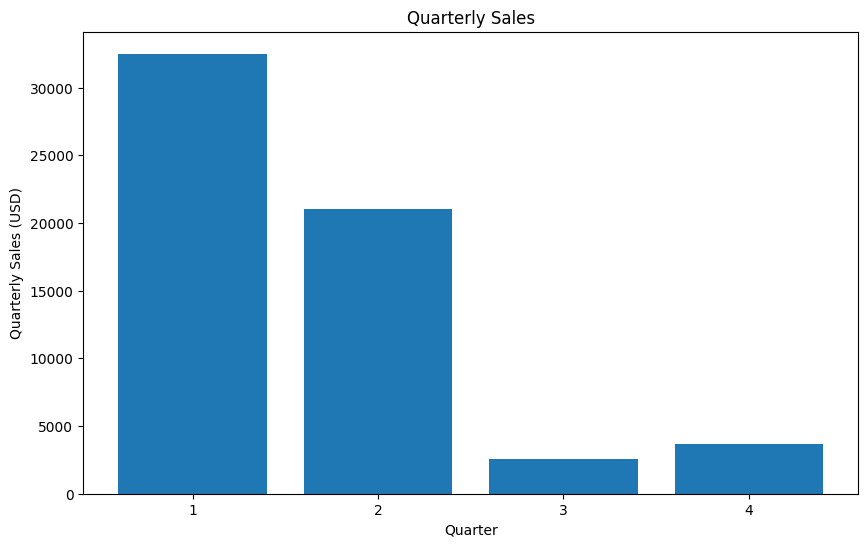

In [ ]:
# 5. Quarterly Sales
sales_df_quarterly_data = sales_df_quarterly.collect()
quarters = [row['Quarter'] for row in sales_df_quarterly_data]
quarterly_sales_usd = [row['Quarterly_Sales_USD'] for row in sales_df_quarterly_data]

plt.figure(figsize=(10, 6))
plt.bar(quarters, quarterly_sales_usd)
plt.xlabel('Quarter')
plt.ylabel('Quarterly Sales (USD)')
plt.title('Quarterly Sales')
plt.xticks(range(1, 5))
plt.show()


In [ ]:
# 6. Calculate the total number of orders by each category
orders_by_category_df = joined_df.groupBy("Product Name").agg(count("Customer Id").alias("Total_Orders"))

# Show total number of orders by each category
orders_by_category_df.show()

+------------+------------+
|Product Name|Total_Orders|
+------------+------------+
|       Pasta|           6|
|       PIZZA|          21|
|    sandwich|          48|
|     Biryani|           6|
|     Chowmin|          24|
|        Dosa|          12|
+------------+------------+



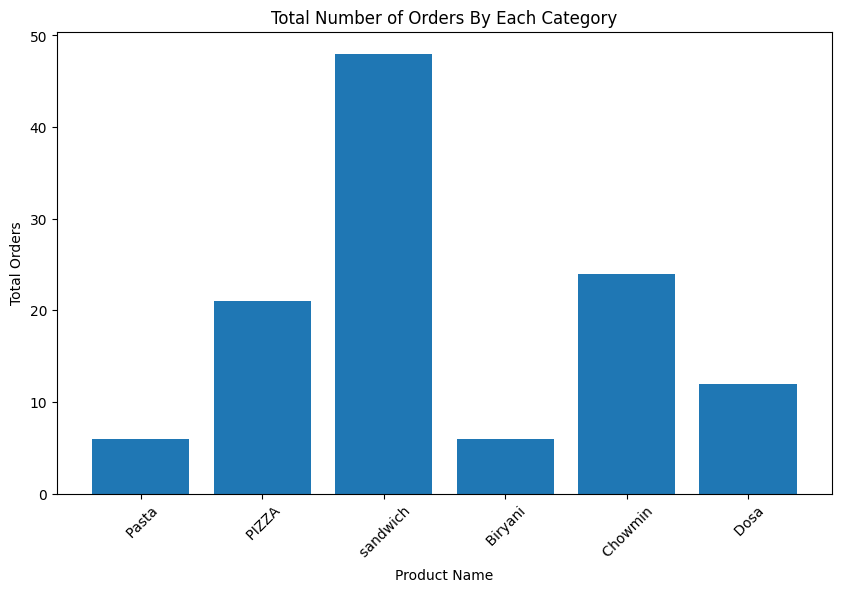

In [ ]:
# 6. Total Number of Orders By each Category
orders_by_category_data = orders_by_category_df.collect()
product_names = [row['Product Name'] for row in orders_by_category_data]
total_orders = [row['Total_Orders'] for row in orders_by_category_data]

plt.figure(figsize=(10, 6))
plt.bar(product_names, total_orders)
plt.xlabel('Product Name')
plt.ylabel('Total Orders')
plt.title('Total Number of Orders By Each Category')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 7 Find the top 5 ordered items
top_5_ordered_items_df = joined_df.groupBy("Product Name") \
    .agg(sum("Quantity").alias("Total_Quantity")) \
    .orderBy(desc("Total_Quantity")) \
    .limit(5)

# Display the top 5 ordered items
top_5_ordered_items_df.show()


+------------+--------------+
|Product Name|Total_Quantity|
+------------+--------------+
|    sandwich|           238|
|     Chowmin|           109|
|       PIZZA|            56|
|        Dosa|            33|
|     Biryani|            25|
+------------+--------------+



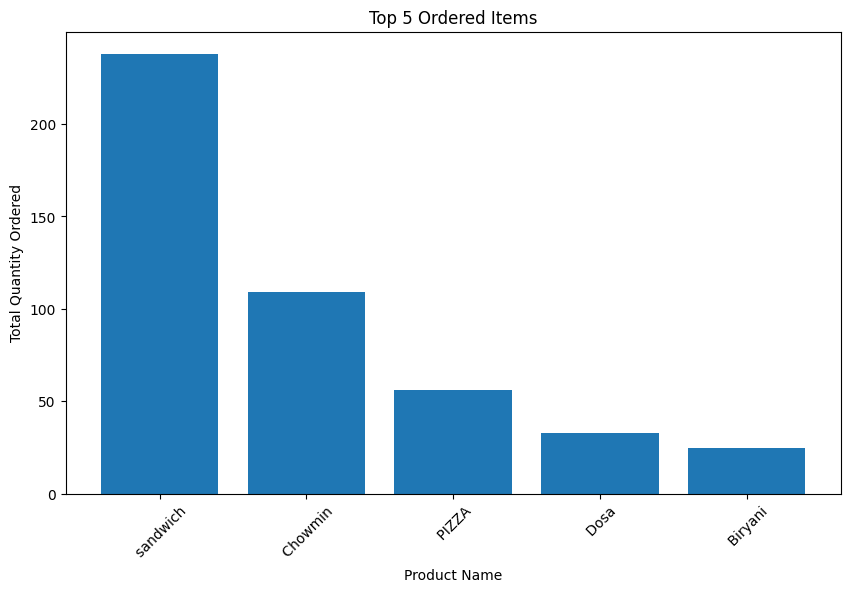

In [ ]:
# 7 Top 5 Ordered Products Visualization
top_5_ordered_items_data = top_5_ordered_items_df.collect()
top_5_product_names = [row['Product Name'] for row in top_5_ordered_items_data]
total_quantity_ordered = [row['Total_Quantity'] for row in top_5_ordered_items_data]

plt.figure(figsize=(10, 6))
plt.bar(top_5_product_names, total_quantity_ordered, color='skyblue')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Ordered')
plt.title('Top 5 Ordered Products')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# 8 Calculate the frequency of customer visits
customer_frequency_df = sales_df.groupBy("Customer Id").agg(count("Product Id").alias("Visit_Frequency")) \
                        .orderBy("Customer Id")

# Display the frequency of customer visits
customer_frequency_df.show()


+-----------+---------------+
|Customer Id|Visit_Frequency|
+-----------+---------------+
|          A|             33|
|          B|             36|
|          C|             18|
|          D|             12|
|          E|             18|
+-----------+---------------+



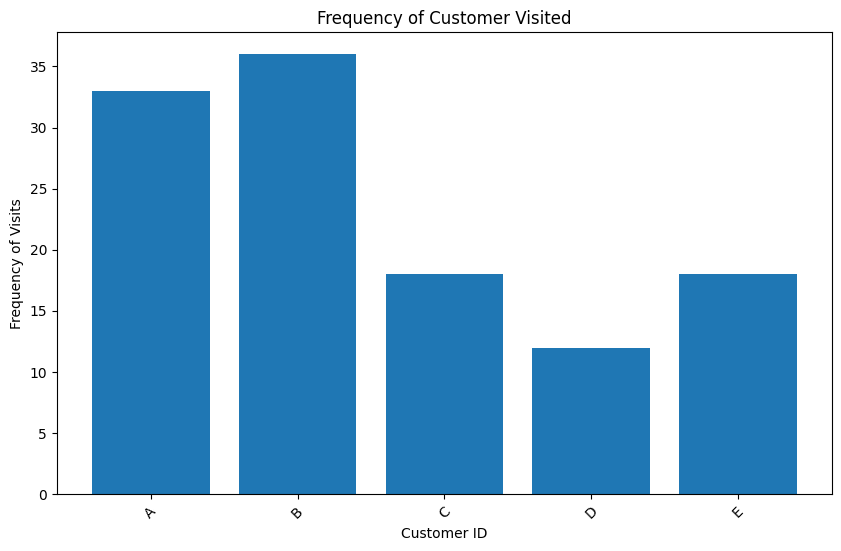

In [ ]:
# 8. Frequency of Customer Visited
customer_frequency_data = customer_frequency_df.collect()
customer_ids = [row['Customer Id'] for row in customer_frequency_data]
visit_frequency = [row['Visit_Frequency'] for row in customer_frequency_data]

plt.figure(figsize=(10, 6))
plt.bar(customer_ids, visit_frequency)
plt.xlabel('Customer ID')
plt.ylabel('Frequency of Visits')
plt.title('Frequency of Customer Visited')
plt.xticks(rotation=45)
plt.show()


In [ ]:
spark.stop()